In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as pd
from pygem_eb.processing.plotting_fxns import *
from objectives import *
import process_outputs as po
import pickle
import os
dsdict = {}
import socket
machine = socket.gethostname()
if 'trace' in machine:
    base_fp = '/trace/group/rounce/cvwilson/Output/'
else:
    base_fp = '/home/claire/research/Output/EB/'

In [2]:
# USER OPTIONS
method = 'MAE'
run_info = {'long':{'date':'11_22', 'idx':'1'},
            '2024':{'date':'11_25', 'idx':'0'}}

for run_type in ['long','2024']:
    date = run_info[run_type]['date']
    idx = run_info[run_type]['idx']
    if not os.path.exists(base_fp + f'{date}_{idx}_out.pkl'):
        # Copy over params from param_set_parallel
        params = {'kw':[1,1.5,2,2.5,3],
                'Boone_c5':[0.018,0.02,0.022,0.024,0.026,0.028],
                'kp':[2.4,2.5,2.6,2.7,2.8,3]}
        if run_type == '2024':
            params['kw'] = [1]

        # Transform params to strings
        for key in params:
            for v,value in enumerate(params[key]):
                params[key][v] = str(value)
        
        # Process output pickle
        po.process_grid_search([date],run_type,params,date_idx=int(idx))

    # Open output pickle
    with open(base_fp + f'{date}_{idx}_out.pkl', 'rb') as file:
        dsdict[run_type] = pickle.load(file)

In [3]:
# Dictionaries with useful information
labels = {'kp':'Precipitation factor','kw':'Wind factor','Boone_c5':'Densification c$_5$'}
methodlabels = {'MAE':'MAE','ME':'Absolute Mean Bias','RMSE':'RMSE'}
medians = {'kp':'2.6','kw':'1','Boone_c5':'0.024'}
sitedict = {'2024':['AB','ABB','B','BD','D','T'],'long':['A','AU','B','D']}
all_sites = sitedict['long']+sitedict['2024']+['mean']

# Store parameters
params = {}
params['kw'] = [val for val in dsdict['long']['B']]
params['Boone_c5'] = [val for val in dsdict['long']['B']['1']]
params['kp'] = [val for val in dsdict['long']['B']['1']['0.026']]

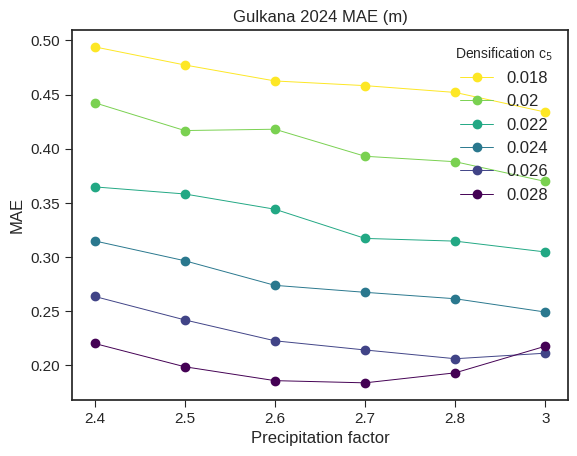

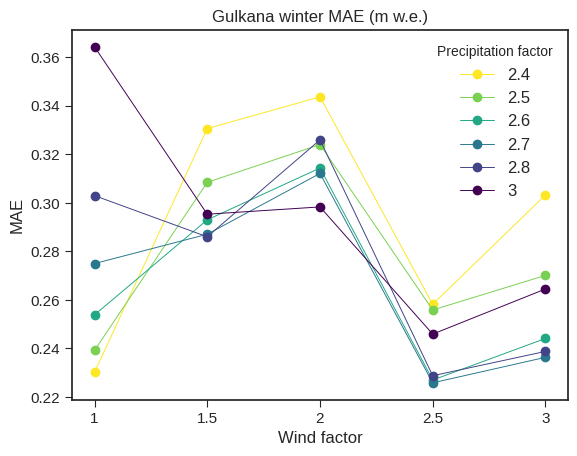

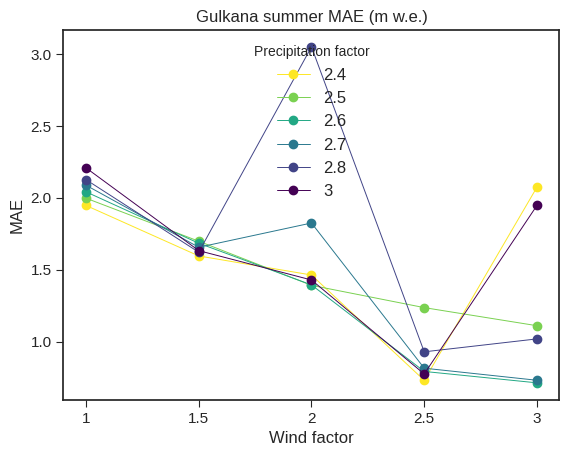

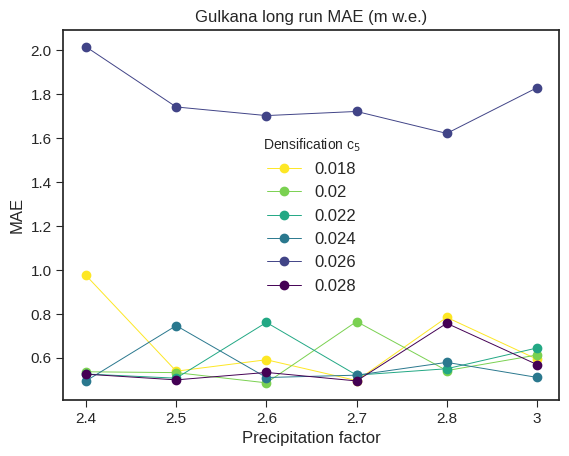

In [16]:
for run_name in ['2024','winter','summer','long']: # '2024']: # 
    # Parse run info
    run = '2024' if run_name == '2024' else 'long'
    if run == 'long':
        err_name = run_name + '_' + method
    else:
        err_name = method
    
    if run_name == '2024':
        param_x = 'kp'
        param_z = 'Boone_c5'
    elif run_name == 'winter':
        param_x = 'kw'
        param_z = 'kp'
    elif run_name == 'summer':
        param_x = 'kw'
        param_z = 'kp'
    elif run_name == 'long':
        param_x = 'kp'
        param_z = 'Boone_c5'
    
    all_sites = sitedict[run]+['mean']

    for site in ['mean']:
        fig,ax = plt.subplots()
        param_x_arr = np.array(params[param_x],dtype=str)
        param_z_arr = np.array(params[param_z],dtype=str)
        errors = np.empty([len(param_x_arr),len(param_z_arr)])

        if 'kw' not in [param_x,param_z]:
            kw = medians['kw']
            if run_name == 'long':
                kw = '2.5'
        if 'kp' not in [param_x,param_z]:
            kp = medians['kp']
        if 'Boone_c5' not in [param_x,param_z]:
            c5 = medians['Boone_c5']

        norm = mpl.colors.Normalize(vmin=0,vmax=len(param_z_arr)-1)
        cmap = mpl.colormaps.get_cmap('viridis_r')
        for zz,zval in enumerate(param_z_arr):
            for xx,xval in enumerate(param_x_arr):
                if param_x == 'kw':
                    kw = xval
                elif param_z == 'kw':
                    kw = zval
                if param_x == 'kp':
                    kp = xval
                elif param_z == 'kp':
                    kp = zval
                if param_x == 'Boone_c5':
                    c5 = xval
                elif param_z == 'Boone_c5':
                    c5 = zval

                if site == 'mean':
                    site_vals = []
                    for s in sitedict[run]:
                        if err_name in dsdict[run][s][kw][c5][kp]:
                            site_vals.append(dsdict[run][s][kw][c5][kp][err_name])
                        elif run_name == 'long':
                            winter = dsdict[run][s][kw][c5][kp]['winter_'+method]
                            summer = dsdict[run][s][kw][c5][kp]['summer_'+method]
                            site_vals.append(np.mean([winter,summer]))
                        else:
                            site_vals.append(np.nan)
                    errors[xx,zz] = np.nanmean(site_vals)
                else:
                    if site in sitedict[run] and err_name in dsdict[run][site][kw][c5][kp]:
                        errors[xx,zz] = dsdict[run][site][kw][c5][kp][err_name]
                    else:
                        errors[xx,zz] = np.nan
            errors = np.abs(errors)
            ax.plot(param_x_arr,errors[:,zz],color=cmap(norm(zz)),label=str(zval),marker='o',linewidth=0.7)
        ax.legend(title=labels[param_z],fontsize=12)
        ax.set_xlabel(labels[param_x],fontsize=12)
        ax.set_ylabel(method,fontsize=12)
        units = 'm w.e.' if run == 'long' else 'm'
        run_name = 'long run' if run_name == 'long' else run_name
        title = f'Gulkana {run_name} {methodlabels[method]} ({units})'
        if site != 'mean':
            title += f' at site {site}'
        ax.set_title(title)
        ax.tick_params(length=5,labelsize=11)
        plt.savefig(f'../Output/EB/{param_z}_vs_{param_x}_{run_name}_{site}.png')
        plt.show()

Find best parameter set

In [4]:
min_err = np.inf
min_long_err = np.inf
min_2024_err = np.inf
method = 'ME'
for kw in params['kw']:
    # kw = '1'
    for c5 in params['Boone_c5']:
        for kp in params['kp']:
            summer_error = []
            winter_error = []
            density_error = []
            s24 = []
            # Find mean long run error across sites and seasons
            if 'long' in dsdict:
                for site in sitedict['long']:
                    if 'summer_'+method in dsdict['long'][site][kw][c5][kp]:
                        summer_error.append(np.abs(dsdict['long'][site][kw][c5][kp][f'summer_{method}']))
                        winter_error.append(np.abs(dsdict['long'][site][kw][c5][kp][f'winter_{method}']))
                        # density_error.append(np.abs(dsdict['long'][site]['1'][c5][kp][f'density_{method}'])/100)
                meanlong = np.mean([summer_error,winter_error]) # 
                if meanlong < min_long_err: # and len(summer_error) == 3:
                    min_long_err = meanlong
                    best_long = [kw,c5,kp]
            # Find mean short run error across sites
            if '2024' in dsdict:
                for site in sitedict['2024']:
                    if method in dsdict['2024'][site]['1'][c5][kp]:
                        s24.append(np.abs(dsdict['2024'][site]['1'][c5][kp][method]))
                mean24 = np.mean(s24)
                if mean24 < min_2024_err:
                    min_2024_err = mean24
                    best_2024 = [kw,c5,kp]
            # Find best overall error
            if '2024' in dsdict and 'long' in dsdict:
                err = np.mean([meanlong,mean24])
                if err < min_err:
                    min_err = err
                    best = [kw,c5,kp]

kw,c5,kp = best_long
print(kw,c5,kp,min_long_err)
kw,c5,kp = best_2024
print(kw,c5,kp,min_2024_err)
kw,c5,kp = best
print(kw,c5,kp,min_err)

3 0.02 2.8 0.23863776363800548
1 0.028 2.7 0.18359829349446036
3 0.028 2.5 0.23943172816057262


Best timeseries

In [30]:
# for ss,site in enumerate(['A','AU','B','D']):
#     if 'run' in dsdict['long'][site][kw][c5][kp]:
#         run = dsdict['long'][site][kw][c5][kp]['run']
#         set = dsdict['long'][site][kw][c5][kp]['set']
#         print(dsdict['long'][site][kw][c5][kp],kw,c5,kp)
#         ds,s,e = getds(base_fp + f'{date}_{idx}/grid_{date}_set{set}_run{run}_0.nc')
#         plot_seasonal_mass_balance(site,ds)
#         # print(ds.attrs)

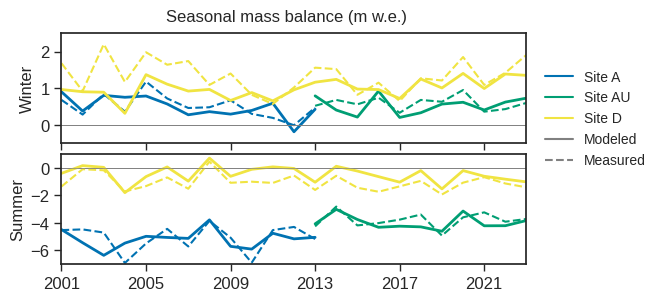

In [41]:
fig, axes = plt.subplots(2,figsize=(6,3),gridspec_kw={'hspace':0.1},sharex=True)
list_plots = []
sites = ['A','AU','D']
colors = np.flip(['#F0E442', '#009E73','#0072B2']) #,'#E69F00'
date = run_info['long']['date']
idx = run_info['long']['idx']

for ss,site in enumerate(sites):
    if 'run' in dsdict['long'][site][kw][c5][kp]:
        run = dsdict['long'][site][kw][c5][kp]['run']
        set = dsdict['long'][site][kw][c5][kp]['set']
        ds,s,e = getds(base_fp + f'{date}_{idx}/grid_{date}_set{set}_run{run}_0.nc')
    else:
        continue        

    color = colors[ss]
    axes[0] = plot_seasonal_mass_balance(site,ds,plot_ax=axes[0],plot_var='bw',color=color)
    axes[1] = plot_seasonal_mass_balance(site,ds,plot_ax=axes[1],plot_var='bs',color=color)
    dummy_site, = axes[1].plot(np.nan,np.nan,color=color)
    list_plots.append(dummy_site)
dummy_model, = axes[1].plot(np.nan,np.nan,color='gray')
dummy_meas, = axes[1].plot(np.nan,np.nan,color='gray',linestyle='--')
list_plots.append(dummy_model)
list_plots.append(dummy_meas)
axes[0].set_ylabel('Winter',fontsize=12)
axes[1].set_ylabel('Summer',fontsize=12)
axes[0].set_ylim(-0.5,2.5)
axes[1].set_ylim(-7,1)
axes[1].set_yticks([0,-2,-4,-6])
for i in range(2):
    axes[i].get_legend().remove()
labels = ['Site '+sss for sss in sites]+['Modeled','Measured']
fig.legend(list_plots,labels,bbox_to_anchor=(1.12,0.8),fontsize=10)
fig.suptitle('Seasonal mass balance (m w.e.)',fontsize=12,y=0.96)
plt.savefig(base_fp+'seasonal_mass_balance.png',dpi=180,bbox_inches='tight')
plt.show()
    # fig, ax = seasonal_mass_balance(site,ds,plot=True)
    # visualize_layers(ds,pd.date_range(s,e,freq='MS'),['layertemp'],plot_ice=True,ylim=55)
    # simple_plot(ds,['2006-08-11','2006-08-12'],[['sensible','latent','SWnet','LWnet','meltenergy']],res='h')
    # ds = ds.resample(time='MS').mean()
    # # ds = ds.sel(time=pd.date_range('2006-05-20','2006-07-30',freq='h'))
    # plt.plot(ds.time.values,ds.sensible+ds.latent+ds.SWnet+ds.LWnet+ds.rain+ds.ground)
    # plt.plot(ds.time.values,ds.meltenergy)
    # plt.show()
    # fig.savefig(f'/trace/group/rounce/cvwilson/Output/best_{site}_{date}.png',dpi=180,bbox_inches='tight')

Site AB internal acc: 0.00002 m w.e.
Site B internal acc: 0.00006 m w.e.
Site D internal acc: 0.07945 m w.e.
Site T internal acc: 0.09399 m w.e.


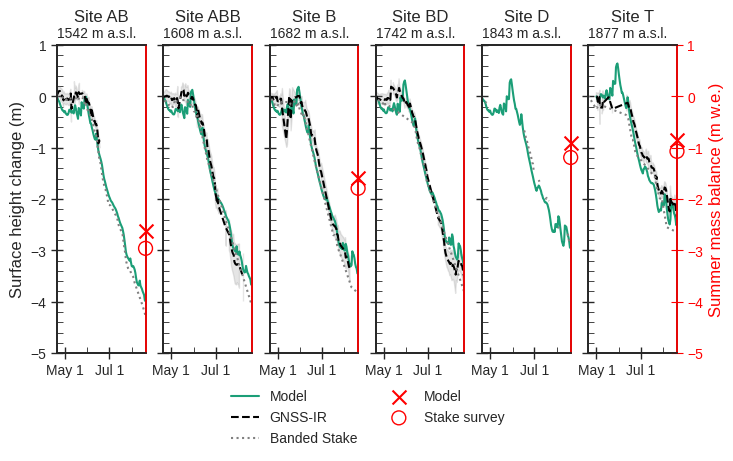

In [25]:
elev = {'AB':1542,'ABB':1608,'B':1682,'BD':1742,'D':1843,'T':1877}
ylim = (-5,1)
fig,axes = plt.subplots(1,6,figsize=(8,4),sharey=True,sharex=True,gridspec_kw={'wspace':0.2})
date = run_info['2024']['date']
idx = run_info['2024']['idx']
for i,site in enumerate(['AB','ABB','B','BD','D','T']):
    if 'run' in dsdict['2024'][site]['1'][c5][kp]:
        run = dsdict['2024'][site]['1'][c5][kp]['run']
        set = dsdict['2024'][site]['1'][c5][kp]['set']
        ds,s,e = getds(base_fp + f'{date}_{idx}/grid_{date}_set{set}_run{run}_0.nc')
    else:
        continue

    if site == 'B':
        bds = ds.copy(deep=True)
    axes[i] = plot_2024_mass_balance(site,ds,plot_ax=axes[i])
    axes[i].set_title(f'Site {site}',fontsize=12,y=1.05)
    axes[i].text(pd.to_datetime('2024-04-20'),1.15,str(elev[site])+' m a.s.l.',fontsize=10)
    axes[i].set_ylabel('')
    # direction = '' if error < 0 else '+'
    # text = f'{direction}{error:.3f} m'
    # axes[i].text(enddate-pd.Timedelta(days=80),0.9,text,fontsize=10)
    
    axes[i].get_legend().remove()
    axes[i].set_xlim(s,e)
    axes[i].set_xticks(pd.date_range(s,e,freq='2MS'))
    axes[i].tick_params(labelsize=10,direction='inout',length=8)
    axes[i].minorticks_on()
    axes[i].tick_params(which='minor', direction='in', length=4)
    axes[i].set_xticklabels(['May 1','Jul 1'])
    axes[i].xaxis.set_minor_locator(mpl.dates.MonthLocator(interval=1))
    twinax = axes[i].twinx()
    if site not in ['ABB','BD']:
        mbmod,mbmeas = cumulative_mass_balance(site,ds,out_mbs=True)
        mod = twinax.scatter(e,mbmod,color='red',marker='x',s=100)
        meas = twinax.scatter(e,mbmeas,color='red',marker='o',facecolors='none',s=100)
        meas.set_clip_on(False)
        mod.set_clip_on(False)
    twinax.set_ylim(ylim)
    twinax.yaxis.set_ticks_position('right')
    for s,spine in enumerate(twinax.spines.values()):
        if s == 1:
            spine.set_edgecolor('red')
    if site=='T':
        twinax.tick_params(labelright=True,labelsize=10,direction='inout',length=8,labelcolor='red',colors='red')
        twinax.set_ylabel('Summer mass balance (m w.e.)',fontsize=12,color='red')
    else:
        twinax.set_yticklabels([])
for ax in axes:
    ax.set_xlim(pd.to_datetime('2024-04-20'),pd.to_datetime('2024-08-20'))
    ax.set_ylim((ylim))
axes[0].set_ylabel('Surface height change (m)',fontsize=12)
l1, = axes[-1].plot(np.nan,np.nan,color=plt.cm.Dark2(0))
l2, = axes[-1].plot(np.nan,np.nan,color='black',linestyle='--')
l3, = axes[-1].plot(np.nan,np.nan,color='gray',linestyle=':')
leg = fig.legend([l1,l2,l3,mod,meas],['Model','GNSS-IR','Banded Stake','Model','Stake survey'],ncols=2,fontsize=10,bbox_to_anchor=(0.7,0.05))
leg.get_frame().set_facecolor('white')
leg.get_frame().set_alpha(1)
# plt.savefig(f'../Output/EB/gulkana_dh_best_params.png',dpi=180,bbox_inches='tight')
plt.show()

PROCESS ERROR IN DENSITY PITS

In [26]:
years = np.arange(2000,2025)
with open('../MB_data/pits.pkl', 'rb') as file:
    site_profiles = pickle.load(file)
# date = '11_18'
# idx = '0'
# for kw in params['kw']:
#     for kp in params['kp']:
#         for c5 in params['Boone_c5']:
#             for site in sitedict['long']:
#                 profiles = site_profiles[site]
#                 if 'run' in dsdict['long'][site][kw][c5][kp]:
#                     run = dsdict['long'][site][kw][c5][kp]['run']
#                     set = dsdict['long'][site][kw][c5][kp]['set']
#                     ds,s,e = getds(base_fp+f'{date}_{idx}/grid_{date}_set{set}_run{run}_0.nc')
#                 else:
#                     continue

#                 # Storage to determine error
#                 yearly_mass_err = []
#                 yearly_density_err = []

#                 # Loop through years
#                 for y,year in enumerate(years):
#                     # Some years don't have data: skip
#                     if year in profiles['sbd']:
#                         # Load data
#                         sbd = profiles['sbd'][year]
#                         dens_meas = profiles['density'][year]

#                         # Load dataset on the date the snowpit was taken
#                         sample_date = profiles['date'][year]
#                         dsyear = ds.sel(time=pd.to_datetime(f'{year}-{sample_date}'))

#                         # Calculate layer density and determine snow indices
#                         ldz = dsyear.layerheight.values
#                         depth_mod = np.array([np.sum(ldz[:i+1])-(ldz[i]/2) for i in range(len(ldz))])
#                         dens_mod = dsyear['layerdensity'].values
#                         snow_idx = np.where(depth_mod < dsyear.snowdepth.values)[0]

#                         # Interpolate modeled density to the snowpit depths
#                         dens_interp = np.interp(profiles['sbd'][year],depth_mod,dens_mod)

#                         # Find the snow depth
#                         snowdepth_mod = depth_mod[snow_idx[-1]]
#                         snowdepth_pit = profiles['sbd'][year][~np.isnan(profiles['sbd'][year])][-1]

#                         # Calculate mass of snow
#                         snowmass_mod = np.sum(dsyear.layerheight.values[snow_idx] * dsyear.layerdensity.values[snow_idx]) / 1000
#                         sample_heights = np.append(np.array([profiles['sbd'][year][0]]),np.diff(np.array(profiles['sbd'][year])))
#                         snowmass_meas = np.sum(profiles['density'][year] * sample_heights) / 1000

#                         # Calculate and store error from mass and density 
#                         density_error = objective(dens_interp, dens_meas, 'MAE') # kg/m3
#                         mass_error = objective(snowmass_mod,snowmass_meas,'MAE') # m w.e.
#                         yearly_mass_err.append(mass_error)
#                         yearly_density_err.append(density_error)
                    
#                 # Store mean error for the c5
#                 dsdict['long'][site][kw][c5][kp]['density_MAE'] = np.mean(yearly_density_err)
#                 dsdict['long'][site][kw][c5][kp]['snowmass_MAE'] = np.mean(yearly_mass_err) 
# # dump results
# with open(base_fp + f'{date}_{idx}/{date}_{idx}_out3.pkl', 'wb') as file:
#     pickle.dump(dsdict['long'],file)

SITE COMPARISON

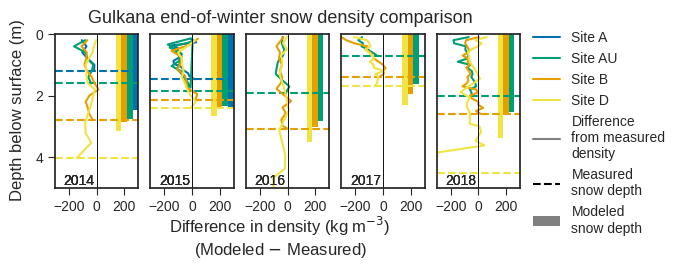

In [40]:
plot_diff = True
# years = np.arange(2000,2025)
years = np.arange(2014,2019)
with open('../MB_data/pits.pkl', 'rb') as file:
    site_profiles = pickle.load(file)
ds_by_site = {'AU':[],'B':[],'D':[]}
colors = np.flip(['#F0E442','#E69F00','#009E73','#0072B2']) # 
fig,axes = plt.subplots(1,5,figsize=(6,2),sharex=True,sharey=True,gridspec_kw={'hspace':0.12,'wspace':0.15})
axes = axes.flatten()
for ss,site in enumerate(sitedict['long']): # sitedict['long']
    # Select site color
    color = colors[ss]

    # Load data for the site
    profiles = site_profiles[site]
    # if 'run' in dsdict['long'][site][kw][c5][kp]:
    #     run = dsdict['long'][site][kw][c5][kp]['run']
    #     set = dsdict['long'][site][kw][c5][kp]['set']
    #     ds,s,e = getds(base_fp+f'{date}_{idx}/grid_{date}_set{set}_run{run}_0.nc')
    # else:
    #     print('missing',site,kw,c5,kp)
    #     continue
    ds,s,e = getds(base_fp+f'Gulkana_2024_11_26_long{site}_0.nc')

    # Loop through years
    for y,year in enumerate(years):
        ax = axes[y]

        # Some years don't have data: skip
        if year in profiles['sbd']:
            # Load data
            sbd = profiles['sbd'][year]
            dens_meas = profiles['density'][year]

            # Load dataset on the date the snowpit was taken
            sample_date = profiles['date'][year]
            dsyear = ds.sel(time=pd.to_datetime(f'{year}-{sample_date}'))

            # Add year to the axis
            coords = [-240,4.9] if plot_diff else [50,4.9]
            ax.text(coords[0],coords[1],str(year),fontsize=10)

            # Calculate layer density and determine snow indices
            ldz = dsyear.layerheight.values
            depth_mod = np.array([np.sum(ldz[:i+1])-(ldz[i]/2) for i in range(len(ldz))])
            dens_mod = dsyear['layerdensity'].values
            snow_idx = np.where(depth_mod < dsyear.snowdepth.values)[0]

            if plot_diff:
                # Interpolate modeled density to the snowpit depths
                dens_interp = np.interp(sbd,depth_mod,dens_mod)
                diff = dens_interp - dens_meas

                # Plot the difference
                ax.plot(diff,profiles['sbd'][year],color=color)
            else:
                # Plot the profiles
                ax.plot(dens_meas,sbd,color=color,linestyle='--')
                ax.plot(dens_mod[snow_idx],depth_mod[snow_idx],color=color)

            # Find the snow depth
            snowdepth_mod = depth_mod[snow_idx[-1]]
            snowdepth_pit = sbd[~np.isnan(sbd)][-1]

            # Plot a horizontal line for the snow depth
            # ax.axhline(snowdepth_mod,color=color)
            # ax.axhline(snowdepth_pit,color=color,linestyle='--')            

            if plot_diff:
                # Plot a bar of the snow depth
                bar_width = 40
                ax.bar(300-(ss+1)*bar_width,snowdepth_mod,width=bar_width,color=color,align='edge')
                ax.axhline(snowdepth_pit,color=color,linestyle='--')

    # Dummy variable for legend
    axes[4].plot(np.nan,np.nan,label=f'Site {site}',color=color)

# Dummy variables for legend
if plot_diff:
    axes[4].plot(np.nan,np.nan,label='Difference\nfrom measured\ndensity',color='grey')
    axes[4].plot(np.nan,np.nan,color='black',linestyle='--',label='Measured\nsnow depth')
    axes[4].bar(np.nan,np.nan,color='gray',label='Modeled\nsnow depth')
else:
    axes[4].plot(np.nan,np.nan,label='Modeled',color='grey')
    axes[4].plot(np.nan,np.nan,label='Measured',color='gray',linestyle='--')

# Format axes
for a,ax in enumerate(axes):
    ax.invert_yaxis()
    ax.set_ylim(5,0)
    ax.set_yticks([0,2,4])
    ax.tick_params(length=5,labelsize=10)
    if plot_diff:
        ax.axvline(0,color='k',linewidth=0.5)
        ax.set_xlim(-300,300)
        ax.set_xticks([-200,0,200])
        fig.supxlabel('Difference in density (kg m$^{-3}$)\n(Modeled $-$ Measured)',fontsize=12,y=-0.25)
    else:
        ax.set_xlim(0,600)
        ax.set_xticks([0,250,500])
        fig.supxlabel('Density (kg m$^{-3}$)',fontsize=12,y=0.04)
    if a % 5 != 0:
        ax.tick_params('y',length=0)
    ax.axvline(0,linewidth=0.5,color='black')
fig.supylabel('Depth below surface (m)',fontsize=12,x=0.05)
axes[4].legend(bbox_to_anchor=(1,1.1))
fig.suptitle(f'Gulkana end-of-winter snow density comparison',fontsize=13,y=1)
plt.savefig(base_fp+'density_pits.png',dpi=180,bbox_inches='tight')
plt.show()

TIMESERIES OF SNOW MASS

NameError: name 'site_profiles' is not defined

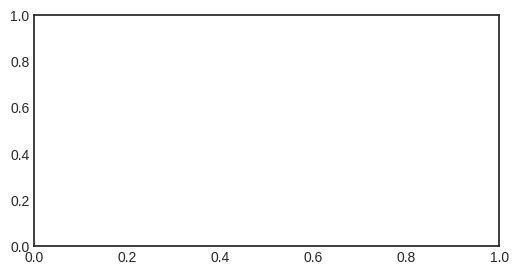

In [25]:
fig,ax = plt.subplots(figsize=(6,3))
for ss,site in enumerate(['B','AU','A']):
    color = colors[ss+1]
    prof = site_profiles[site]
    snowmass_meas_list = []
    snowmass_mod_list = []
    if 'run' in dsdict['long'][site][kw][c5][kp]:
        run = dsdict['long'][site][kw][c5][kp]['run']
        set = dsdict['long'][site][kw][c5][kp]['set']
        ds,s,e = getds(f'/trace/group/rounce/cvwilson/Output/{date}_{idx}/grid_{date}_set{set}_run{run}_0.nc')
    else:
        print('missing',site,kw,c5,kp)
        continue
    for year in years:
        year = int(year)
        if year in prof['sbd']:
            sample_heights = np.append(np.array([prof['sbd'][year][0]]),np.diff(np.array(prof['sbd'][year])))
            snowmass_meas = np.sum(prof['density'][year] * sample_heights) / 1000
            snowmass_meas_list.append(snowmass_meas)
        else:
            snowmass_meas_list.append(np.nan)
        
        # Load dataset on the date the snowpit was taken
        if year in profiles['date']:
            sample_date = profiles['date'][year]
        else:
            sample_date = '04-20'
        dsyear = ds.sel(time=pd.to_datetime(f'{year}-{sample_date}'))

        # Calculate layer density and determine snow indices
        ldz = dsyear.layerheight.values
        depth_mod = np.array([np.sum(ldz[:i+1])-(ldz[i]/2) for i in range(len(ldz))])
        dens_mod = dsyear['layerdensity'].values
        snow_idx = np.where(depth_mod < dsyear.snowdepth.values)[0]

        snowmass_mod = np.sum(dsyear.layerheight.values[snow_idx] * dsyear.layerdensity.values[snow_idx]) / 1000
        snowmass_mod_list.append(snowmass_mod)
    ax.plot(years,snowmass_mod_list,color=color)
    ax.plot(years,snowmass_meas_list,color=color,linestyle='--')
ax.tick_params(length=5,labelsize=10)
ax.set_xlim(2000,2024)
ax.set_ylabel('Mass of snow (m w.e.)')
ax.set_title('Spring field date mass of snow (integrated snow pits)')

DIFFERENCE COMPARISON

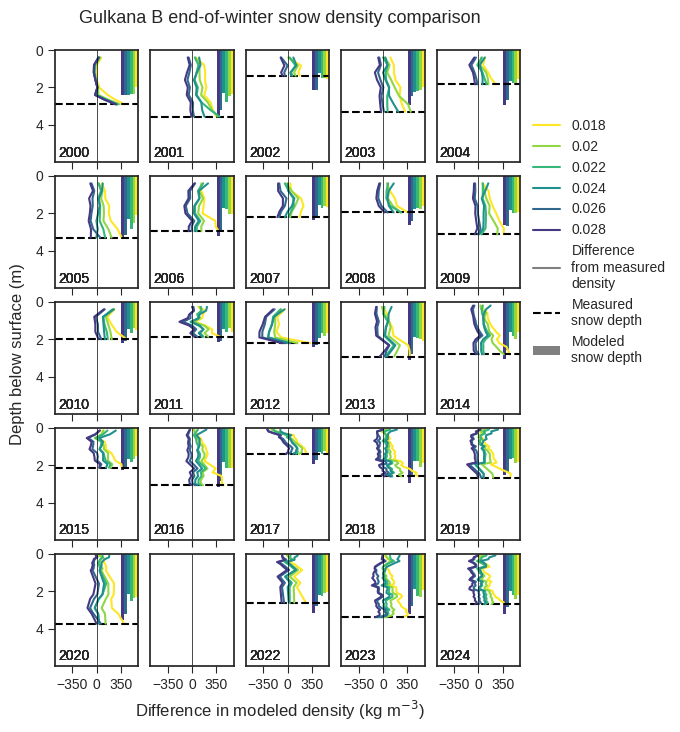

In [ ]:
fig,axes = plt.subplots(5,5,figsize=(6,8),sharex=True,sharey=True,gridspec_kw={'hspace':0.12,'wspace':0.15})
axes = axes.flatten()
norm = mpl.colors.Normalize(vmin=0,vmax=len(params['Boone_c5']))
cmap = mpl.colormaps.get_cmap('viridis_r')
site = 'B'

# Loop through c5 values
for cc,c5 in enumerate(params['Boone_c5']):
    # Grab color for the value
    color = cmap(norm(cc))

    # Load in the datasets for the site
    ds = dsdict['long']
    profiles = site_profiles[site]
    
    # Loop through years (subplots)
    for y,year in enumerate(years):
        ax = axes[y]

        # Some years don't have data: skip
        if year in profiles['sbd']:
            # Load data
            sbd = profiles['sbd'][year]
            dens_meas = profiles['density'][year]

            # Load dataset on the date the snowpit was taken
            sample_date = profiles['date'][year]
            dsyear = ds.sel(time=pd.to_datetime(f'{year}-{sample_date}'))

            # Calculate layer density and determine snow indices
            ldz = dsyear.layerheight.values
            depth_mod = np.array([np.sum(ldz[:i+1])-(ldz[i]/2) for i in range(len(ldz))])
            dens_mod = dsyear['layerdensity'].values
            snow_idx = np.where(depth_mod < dsyear.snowdepth.values)[0]

            # Interpolate modeled density to the snowpit depths
            dens_interp = np.interp(sbd,depth_mod,dens_mod)
            diff = dens_interp - dens_meas

            # Plot the difference
            ax.plot(diff,profiles['sbd'][year],color=color)

            # Add year to the axis
            ax.text(-560,5.7,str(year),fontsize=10)

            # Find the snow depth
            snowdepth_mod = dsyear.snowdepth.values
            snowdepth_pit = sbd[~np.isnan(sbd)][-1]
            
            # Plot a bar of the snow depth
            bar_width = 40
            ax.bar(600-(cc+1)*bar_width,snowdepth_mod,width=bar_width,color=color,align='edge')
            if cc == 0:
                ax.axhline(snowdepth_pit,color='black',linestyle='--')

    # Add dummy variable for legend
    axes[4].plot(np.nan,np.nan,label=c5,color=color)

# Dummy variables for legend
axes[4].plot(np.nan,np.nan,label='Difference\nfrom measured\ndensity',color='grey')
axes[4].plot(np.nan,np.nan,color='black',linestyle='--',label='Measured\nsnow depth')
axes[4].bar(np.nan,np.nan,color='gray',label='Modeled\nsnow depth')

# Format axes
for a,ax in enumerate(axes):
    ax.invert_yaxis()
    ax.set_ylim(6,0)
    ax.set_yticks([0,2,4])
    ax.tick_params(length=5,labelsize=10)
    ax.set_xlim(-600,600)
    ax.set_xticks([-350,0,350])
    if a % 5 != 0:
        ax.tick_params('y',length=0)
    ax.axvline(0,linewidth=0.5,color='black')
fig.supxlabel('Difference in modeled density (kg m$^{-3}$)',fontsize=12,y=0.04)
fig.supylabel('Depth below surface (m)',fontsize=12,x=0.05)
axes[4].legend(bbox_to_anchor=(1,0.5))
fig.suptitle(f'Gulkana {site} end-of-winter snow density comparison',fontsize=13,y=0.93)
# plt.show()
plt.savefig(f'../Output/EB/gulkana{site}_pits_modeled.png',dpi=220,bbox_inches='tight')

Compare albedo

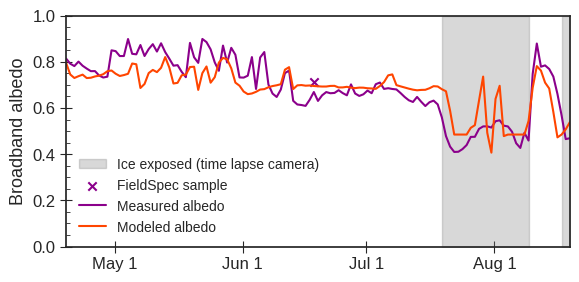

In [23]:
df = pd.read_csv('/trace/home/cvwilson/research/climate_data/AWS/Preprocessed/gulkana2024_walbedo.csv',index_col=0)
df.index = pd.to_datetime(df.index) # - pd.Timedelta(hours=8)
# df['albedo'] = df['SWout'] / df['SWin']
# bds,s,e = getds('../Output/EB/Gulkana_2024_11_24_1.nc')
bds,s,e = getds(base_fp+'Gulkana_11_26_2024B_0.nc')
bds = bds.resample(time='d').mean()
daily_albedo = []
ice_albedo = []
dates = pd.date_range('2024-04-20','2024-08-20',freq='d')
dates_ice = np.concatenate([pd.date_range('2024-07-20','2024-08-10'),pd.date_range('2024-08-18','2024-08-22')])
for date in dates:
    start = pd.to_datetime(str(date.date())+' 12:00')
    end = pd.to_datetime(str(date.date())+' 16:00')
    # print(df.loc[start:end,'albedo'].values)
    daily_albedo.append(np.mean(df.loc[start:end,'albedo']))
    if date in dates_ice:
        ice_albedo.append(np.mean(df.loc[start:end,'albedo']))
y = np.arange(0,1.1,0.1)
fig,ax = plt.subplots(figsize=(6.5,3))
ax.fill_betweenx(y,[pd.to_datetime('2024-08-10')],[pd.to_datetime('2024-07-20')],color='grey',alpha=0.3,label='Ice exposed (time lapse camera)')
ax.fill_betweenx(y,[pd.to_datetime('2024-08-18')],[pd.to_datetime('2024-08-22')],color='grey',alpha=0.3)
ax.scatter(pd.to_datetime('2024-06-19'),0.7123,marker='x',color='darkmagenta',label='FieldSpec sample')
ax.plot(dates,daily_albedo,label='Measured albedo',color='darkmagenta') #,linestyle='--')
ax.plot(bds.time,bds['albedo'],label='Modeled albedo',color='orangered')

ax.set_xlim(dates[0],dates[-1])
ax.set_ylim(0,1)
ax.tick_params(which='major',labelsize=12,length=8,direction='inout')
ax.minorticks_on()
ax.tick_params(axis='x',which='minor',bottom=False)
ax.tick_params(axis='y',which='minor',length=3,direction='in')
ax.legend(fontsize=10)
ax.set_ylabel('Broadband albedo',fontsize=13)
ax.set_xticks(pd.date_range(s,e,freq='MS'))
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b %d'))
ax.set_xticklabels(['May 1','Jun 1','Jul 1','Aug 1'])
# ax.set_title(f'Mean ice albedo: {np.mean(ice_albedo):.3f}',fontsize=12)
# fig.suptitle('Daily albedo (mean of 12:00 - 16:00) at Gulkana B, summer 2024',fontsize=13,y=1.03)
plt.savefig(base_fp+'gulkana_albedo_2024.png',dpi=150,bbox_inches='tight')
plt.show()
print()

(<Figure size 640x480 with 1 Axes>,
 <Axes: ylabel='Seasonal mass balance (m w.e.)'>)

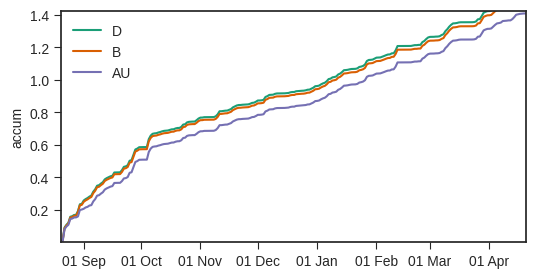

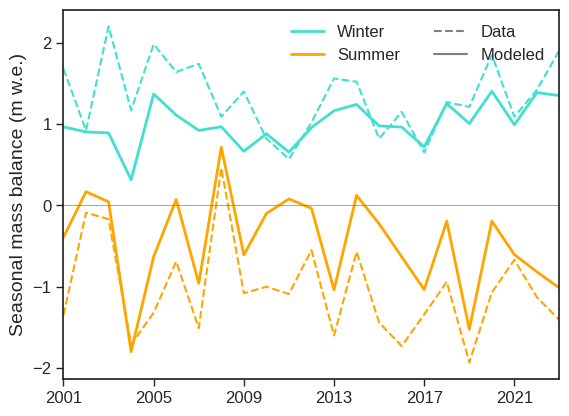

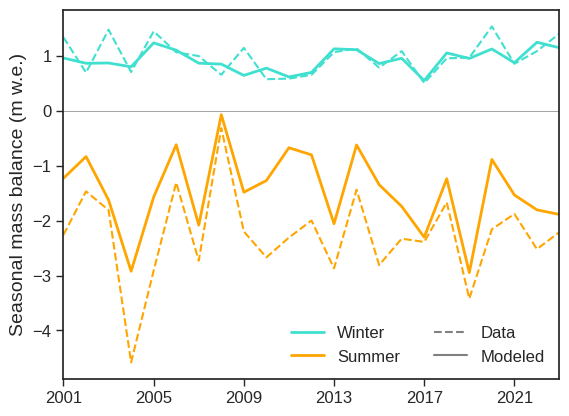

In [24]:
dsD,s,e = getds(base_fp + 'Gulkana_2024_11_26_longD_0.nc')
dsB,s,e = getds(base_fp + 'Gulkana_2024_11_26_longB_0.nc')
dsAU,s,e = getds(base_fp + 'Gulkana_2024_11_26_longAU_0.nc')
s,e = [pd.to_datetime('2000-08-20'),pd.to_datetime('2001-04-20')]
compare_runs([dsD,dsB,dsAU],[s,e],['D','B','AU'],'accum')
plot_seasonal_mass_balance('D',dsD)
plot_seasonal_mass_balance('B',dsB)

[26.63872873 21.13016541  8.45766788  2.8065406   2.13172199]


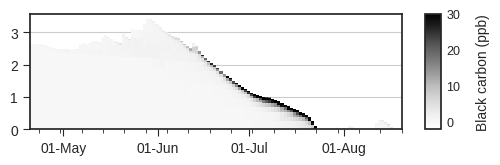

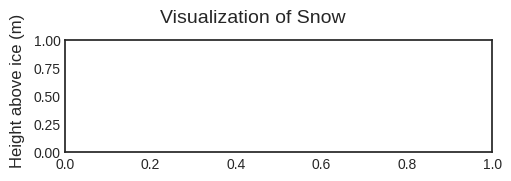

In [ ]:
ds,s,e = getds(base_fp + f'Gulkana_11_26_2024B_0.nc')
# plot_2024_mass_balance('B',ds)
fig,ax = plt.subplots(figsize=(6,1.5))
ax = visualize_layers(ds,pd.date_range(s,e),['layerBC'],plot_ax=[ax])[0]
fig.suptitle('')
ax.minorticks_on()
ax.set_xticks(pd.date_range('2024-04-20','2024-08-20',freq='MS'))
ax.set_xlim(pd.to_datetime('2024-04-20'),pd.to_datetime('2024-08-20'))
ax.tick_params(axis='y',which='minor',bottom=False)
ax.xaxis.set_minor_locator(mpl.dates.WeekdayLocator(interval=1))
ax.tick_params(axis='x',which='minor', direction='out', length=3)
print(ds.sel(time=pd.to_datetime('2024-06-20 14:00')).layerBC.values[0:5])

[24.80088653 19.30786468  6.46185785  2.15160539  1.2778617 ]


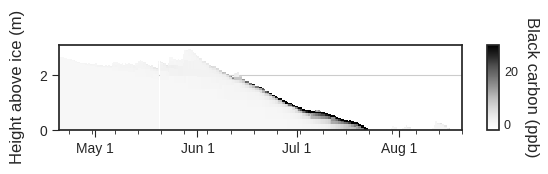

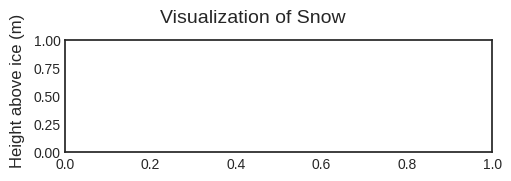

In [33]:
ds,s,e = getds(base_fp + f'Gulkana_11_26_2024B_3.nc')
# plot_2024_mass_balance('B',ds)
fig,ax = plt.subplots(figsize=(6.5,1.1))
ax = visualize_layers(ds,pd.date_range(s,e,freq='12h'),['layerBC'],plot_ax=[ax])[0]
fig.suptitle('')
ax.minorticks_on()
ax.set_xticks(pd.date_range('2024-04-20','2024-08-20',freq='MS'))
ax.set_xlim(pd.to_datetime('2024-04-20'),pd.to_datetime('2024-08-20'))
ax.tick_params(axis='y',which='minor',bottom=False)
ax.xaxis.set_minor_locator(mpl.dates.WeekdayLocator(interval=1))
ax.tick_params(axis='x',which='minor', direction='out', length=3)
fig.supylabel('Height above ice (m)',fontsize=12,x=0.05)
ax.set_xticklabels(['May 1','Jun 1','Jul 1','Aug 1'])
print(ds.sel(time=pd.to_datetime('2024-06-20 14:00')).layerBC.values[0:5])
fig.savefig(base_fp+'snow_BC.png',dpi=180,bbox_inches='tight')

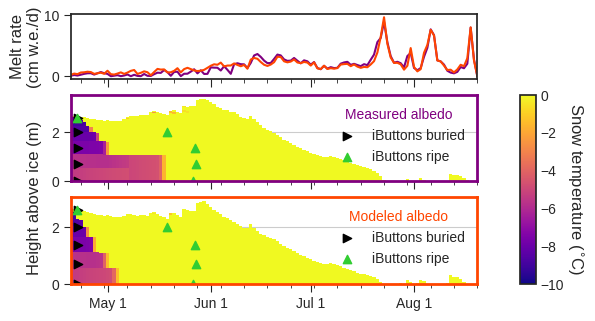

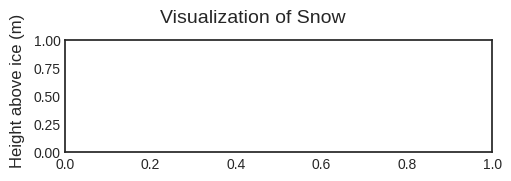

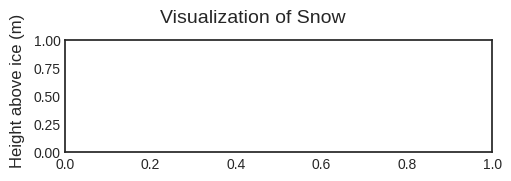

In [12]:
ripe_dict = {'AU': {10: pd.Timestamp('2024-04-21 22:45:00'), 40: pd.Timestamp('2024-04-26 05:30:00'), 80: pd.Timestamp('2024-05-01 14:30:00'), 150: pd.Timestamp('2024-04-27 14:30:00')}, 'B': {10: pd.Timestamp('2024-04-21 21:15:00'), 70: pd.Timestamp('2024-05-18 20:15:00'), 135: pd.Timestamp('2024-05-27 08:45:00'), 200: pd.Timestamp('2024-05-27 11:30:00'), 270: pd.Timestamp('2024-05-26 18:30:00')}, 'D': {10: pd.Timestamp('2024-06-01 18:00:00'), 40: pd.Timestamp('2024-06-02 14:15:00'), 80: pd.Timestamp('2024-06-02 16:45:00'), 120: pd.Timestamp('2024-06-05 14:00:00'), 150: pd.Timestamp('2024-06-05 08:45:00')}}
fig = plt.figure(figsize=(6,3.5))
mosaic = """
        A.
        BD
        CD
"""
ax_dict = fig.subplot_mosaic(mosaic,height_ratios=[1.5,2,2],width_ratios=[1,0.04])
labels = ['Measured albedo','Modeled albedo']
colors = ['purple','orangered']
site = 'B'
for id in [0,1]:
    ripe_dates = {}
    iidd = 2 if id == 0 else 3
    ds,s,e = getds(base_fp + f'Gulkana_11_26_2024B_{iidd}.nc')
    ax_letter = 'B' if id == 0 else 'C'
    if site =='D':
        ax_dict[ax_letter] = visualize_layers(ds,pd.date_range('2024-04-20','2024-08-20'),['layertemp'],ylim=10,plot_ax=[ax_dict[ax_letter]],colorbar=False)[0]
    else:
        ax_dict[ax_letter] = visualize_layers(ds,pd.date_range('2024-04-20','2024-08-20'),['layertemp'],plot_ax=[ax_dict[ax_letter]],colorbar=False)[0]
    ax = ax_dict[ax_letter]

    # Scatter initial heights of iButtons
    depths = np.array([f for f in ripe_dict[site]])
    heights = depths[-1] - depths
    start = np.array([pd.to_datetime('2024-04-22') for _ in range(len(heights))])
    if site == 'D':
        heights += 1200
    ax.scatter(start,heights/100,color='black',marker='>',label='iButtons buried')
    
    # Scatter ripened dates for each sensor
    for depth in ripe_dict[site]:
        if site != 'B':
            height = 150 - depth
        else:
            height = 270 - depth
        if site == 'D':
            height += 1200
        ax.scatter(ripe_dict[site][depth],height/100,marker='^',color='limegreen')
    ax.scatter(np.nan,np.nan,marker='^',color='limegreen',label='iButtons ripe')

    # Add melt rates
    ds = ds.resample(time='d').sum()
    ax_dict['A'].plot(ds.time.values,ds.melt.values*100,label=labels[id],color=colors[id]) # ,width=pd.Timedelta(hours=25)
    ax_dict['A'].set_ylabel('Melt rate\n(cm w.e./d)',fontsize=12)
    ax_dict['A'].yaxis.set_label_coords(-0.07,0.5)
    ax_dict['A'].tick_params(length=5)
    # ax_dict['A'].legend(fontsize=10)
    leg = ax.legend(title=labels[id])
    leg.get_title().set_color(colors[id])
    ax.yaxis.grid(True)
    for spine in ax.spines.values():
        spine.set_edgecolor(colors[id])
        spine.set_linewidth(2)
ax.set_ylabel('Height above ice (m)',fontsize=12)
ax.yaxis.set_label_coords(-0.07,1)
    
for aaa in ['A','B','C']:
    ax = ax_dict[aaa]
    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d-%b'))
    ax.tick_params(axis='x',which='major', direction='out', length=6)
    ax.minorticks_on()
    ax.set_xticks(pd.date_range('2024-04-20','2024-08-20',freq='MS'))
    ax.set_xlim(pd.to_datetime('2024-04-20'),pd.to_datetime('2024-08-20'))
    ax.tick_params(axis='y',which='minor',bottom=False)
    ax.xaxis.set_minor_locator(mpl.dates.WeekdayLocator(interval=1))
    ax.tick_params(axis='x',which='minor', direction='out', length=3)
    ax.set_xticklabels([])
ax_dict['C'].set_xticklabels(['May 1','Jun 1','Jul 1','Aug 1'])
sm = mpl.cm.ScalarMappable(cmap='plasma',norm=plt.Normalize(-10,0))
cb = fig.colorbar(sm,aspect=7,fraction=0.02,orientation='vertical',cax=ax_dict['D'])
cb.set_label('Snow temperature ($^{\circ}$C)',rotation=270,labelpad=15,fontsize=12)
# plt.show()
fig.savefig(base_fp + 'snow_ripening.png',dpi=180,bbox_inches='tight')

ACTUAL CALIBRATION

In [234]:
path_out = '/home/claire/research/Output/calibration/09_24/'

# Parameter sets
aa = [0.2,0.4,0.6]
ww = [0.25,0.5,0.75,1]
kk = ['Sturm','Douville','Jansson'] #,'OstinAndersson','VanDusen']
params_dict = {'kw':ww,'k_snow':kk,'a_ice':aa} # 'kw':ww,

# Get the lengths of each parameter list for the result array shape
shape = [len(v) for v in params_dict.values()]

# Initialize result arrays with a dimension for site (3 sites + 1 for the average)
winter_result = np.ones([4] + shape)
summer_result = np.ones([4] + shape)

# Initialize lists for storing the parameters
params_list = {key: [] for key in params_dict}

# Generate combinations of all parameters
all_combos = itertools.product(*params_dict.values())
for idx, param_values in enumerate(all_combos):
    # Unpack indices
    indices = np.unravel_index(idx, shape)

    # Store parameter set
    for param_name, param_value in zip(params_dict.keys(), param_values):
        params_list[param_name].append(param_value)
    
    # Iterate over sites
    for s, site in enumerate(['AB', 'B', 'D']):
        kw = 0.25 if site == 'D' else 1
        fn = f'kw{kw}_'

        # fn = ''
        for param_name, param_value in zip(params_dict.keys(), param_values):
            fn += param_name.replace('_','')+str(param_value)+'_'
        fn += f'site{site}_0.nc'

        try:
            ds, startdate, enddate = getds(path_out + fn)
            winter, summer = seasonal_mass_balance(data_fp, ds, site=site, method='MAE')
        except:
            winter, summer = (np.nan, np.nan)
            print(fn + ' does not exist')
        
        # Store results in the corresponding array
        winter_result[s][indices] = winter
        summer_result[s][indices] = summer

    # Compute site averages and store in the last index (3rd index in the result arrays)
    winter_result[3][indices] = np.mean(winter_result[:3,*indices])
    summer_result[3][indices] = np.mean(summer_result[:3,*indices])